## Predicting next lab results

#### 배경
- 환자가 받은 다양한 치료로 근미래의 검사 결과를 맞출 수 있을까?

#### 문제 종류
- binary classification (검사 결과가 정상범위인지 아닌지)

#### 실험
- Sepsis 환자를 대상으로 다음 lab 검사 결과의 정상범위 여부를 예측
    - Variables used in SOFA:
    -  GCS, MAP, FiO2, Ventilation status (sourced from CHARTEVENTS)
    -  Creatinine, Bilirubin, FiO2, PaO2, Platelets (sourced from LABEVENTS)
    -  Dobutamine, Epinephrine, Norepinephrine (sourced from INPUTEVENTS_MV and INPUTEVENTS_CV)
    -  Urine output (sourced from OUTPUTEVENTS)

#### 교차검증

#### 평가

#### 예측값의 활용
- 수련의 교육용

첫번째 검사 결과 예측 대상 : Fi02
- https://github.com/MIT-LCP/mimic-code/blob/master/notebooks/aline/aline_sofa.sql

In [1]:
import sys
sys.path.insert(0, './db')
import db_con
import sqlalchemy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Fi02 itemid 찾기
engine = db_con.get_engine()
pd.read_sql_query("""
            SELECT *
            FROM d_items
            WHERE label LIKE '%%FiO2%%';
            """, engine)

,row_id,itemid,label,abbreviation,dbsource,linksto,category,unitname,param_type,conceptid
0,190,189,FiO2 (Analyzed),None,carevue,chartevents,None,None,None,None
1,191,190,FiO2 Set,None,carevue,chartevents,None,None,None,None
2,192,191,FiO2/O2 Delivered,None,carevue,chartevents,None,None,None,None
3,676,727,Vision FiO2,None,carevue,chartevents,None,None,None,None
4,3240,1863,HFO-FiO2,None,carevue,chartevents,None,None,None,None
5,2047,5955,Analyzed INOV FiO2,None,carevue,chartevents,None,None,None,None
6,3911,2981,FiO2,None,carevue,chartevents,None,None,None,None
7,14686,227009,FiO2_ApacheIV_old,FiO2_ApacheIV_old,metavision,chartevents,Scores - APACHE IV (2),None,Numeric,None
8,14687,227010,FiO2_ApacheIV,FiO2_ApacheIV,metavision,chartevents,Scores - APACHE IV (2),%,Numeric,None
9,14515,226754,FiO2ApacheIIValue,FiO2ApacheIIValue,metavision,chartevents,Scores - APACHE II,%,Numeric,None


## 의학 의견
- Item선정 기준

In [3]:
# sepsis diagnosis 환자들의 FiO2 기록(입원 시점으로 분단위)
pat = pd.read_sql("""
                SELECT
                chi.icustay_id,
                chi.mins,
                chi.itemid,
                chi.valuenum,
                d_items.label
                FROM (
                SELECT
                 ch.icustay_id,
                 EXTRACT(MINS FROM ch.charttime - ic.intime) AS mins,
                 ch.itemid,
                 ch.value,
                 ch.valuenum
                FROM (SELECT *
                     FROM chartevents
                       LEFT JOIN diagnoses_icd di
                         ON chartevents.subject_id = di.subject_id
                     WHERE di.icd9_code IN ('77181', '99591', '99592', '67020', '67022', '67024')
                           AND chartevents.itemid IN (3420, 190, 223835, 3422)) AS ch LEFT JOIN icustays ic
                   ON ch.icustay_id = ic.icustay_id
                ) AS chi
                LEFT JOIN d_items
                ON chi.itemid = d_items.itemid
                """, engine)

In [4]:
pat.shape
pat.head()

(765467, 5)

,icustay_id,mins,itemid,valuenum,label
0,217847.0,9.0,190,1.0,FiO2 Set
1,217847.0,39.0,190,1.0,FiO2 Set
2,248910.0,30.0,190,0.5,FiO2 Set
3,248910.0,30.0,190,0.4,FiO2 Set
4,248910.0,15.0,190,0.4,FiO2 Set


In [5]:
pat.describe()

,icustay_id,mins,itemid,valuenum
count,763485.000000,763485.000000,765467.000000,764199.000000
mean,249582.363470,29.545763,83246.665774,34.111892
std,28286.896316,17.684213,106797.148410,28.783998
min,200001.000000,-59.000000,190.000000,0.000000
25%,226799.000000,14.000000,190.000000,1.000000
50%,249403.000000,30.000000,3420.000000,37.000000
75%,273763.000000,44.000000,223835.000000,47.000000
max,299998.000000,59.000000,223835.000000,7050.000000


In [6]:
pat = pat[~pat.icustay_id.isna()]
pat = pat[pat.mins>=0]
pat.shape

(762064, 5)

## 전처리
pre-process the FiO2s to ensure they are between 21-100%

In [7]:
pat = pat[(pat.valuenum>21) | ((pat.valuenum<1) & (pat.valuenum>0))]
pat.shape

(698867, 5)

In [8]:
# 제거 되었는지 확인
pat[(pat.valuenum<21) & (pat.valuenum<0.2)]

,icustay_id,mins,itemid,valuenum,label


In [9]:
# 백분위로 변환
def convert_to_percent(num):
    return num * 100

pat.loc[pat.valuenum<1, 'valuenum'] = pat[pat.valuenum<1].valuenum.map(lambda x: convert_to_percent(x))

pat[pat.valuenum<1]

,icustay_id,mins,itemid,valuenum,label


In [10]:
pat.valuenum.describe()

count    698867.000000
mean         47.669281
std          21.504678
min          20.999999
25%          40.000000
50%          40.000001
75%          50.000000
max        7050.000000
Name: valuenum, dtype: float64

## 한 환자의 FiO2값 예측하기

In [11]:
# 가장 긴 관찰 값을 가지고 있는 환자 찾기
find_pat = pat.groupby(['mins', 'icustay_id']).mean().reset_index().pivot("icustay_id", 'mins', 'valuenum')
find_pat.isnull().sum(axis=1).sort_values(ascending=True)

icustay_id
252836.0     0
295669.0     0
249403.0     0
298236.0     0
294193.0     0
226799.0     0
209663.0     0
249864.0     0
238858.0     0
225650.0     0
            ..
243916.0    59
243886.0    59
243855.0    59
284987.0    59
243793.0    59
243791.0    59
243622.0    59
243592.0    59
243429.0    59
238757.0    59
Length: 5484, dtype: int64

In [12]:
target_pat = find_pat.iloc[find_pat.index==295669].values[0]
target_pat

array([56.52173913, 56.52173913, 56.52173913, 56.52173913, 56.30434783,
       56.30434783, 55.33333333, 56.30434783, 56.30434783, 56.30434783,
       56.30434783, 57.23404255, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 55.43478261, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       55.88235294, 56.38297872, 56.38297872, 56.38297872, 56.52173913])

In [13]:
train, test = target_pat[0:len(target_pat)-10], target_pat[len(target_pat)-10:]
train
test

array([56.52173913, 56.52173913, 56.52173913, 56.52173913, 56.30434783,
       56.30434783, 55.33333333, 56.30434783, 56.30434783, 56.30434783,
       56.30434783, 57.23404255, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 55.43478261, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872])

array([56.38297872, 56.38297872, 56.38297872, 56.38297872, 56.38297872,
       55.88235294, 56.38297872, 56.38297872, 56.38297872, 56.52173913])

## Time series 데이터를 기반으로 다음 값을 예측하기

- Model : Autoregression(자기회귀)
    - output values based on a linear combination of input values
    - 앞선 관측값이 다음 값을 예측하는데 효과적이라는 가정을 기반으로 한다.
    - 만약 input과 output이 같은 방향(같이 증가하거나 같이 감소하거나)으로 변화한다면 positive correlation이라고 지칭하고, 반대 방향으로 변화한다면 negative correlation이라고 한다.
    - y = b0 + b1*x1 
    -> x(t+1) = b0 + b1*x(t-1) + b2*x(t-2)....

In [14]:
from statsmodels.tsa.ar_model import AR

model = AR(train)
model_fit = model.fit()
print('Lag : %s' % model_fit.k_ar)
print('Coefficients : %s' % model_fit.params)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('Predicted= %f, expected=%f' % (predictions[i], test[i]))

Lag : 10
Coefficients : [ 1.42052161e+02 -3.49874631e-01 -1.15568316e-01 -3.47879775e-02
 -1.48938756e-02 -3.52998640e-01 -4.33378673e-01 -1.48015192e-01
  1.56954886e-03  2.15910593e-02 -9.38904512e-02]
Predicted= 56.336098, expected=56.382979
Predicted= 56.352501, expected=56.382979
Predicted= 56.352180, expected=56.382979
Predicted= 56.352027, expected=56.382979
Predicted= 56.352245, expected=56.382979
Predicted= 56.368502, expected=55.882353
Predicted= 56.377326, expected=56.382979
Predicted= 56.372299, expected=56.382979
Predicted= 56.370161, expected=56.382979
Predicted= 56.369991, expected=56.521739


In [15]:
from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.027


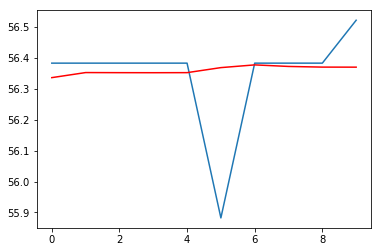

In [16]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [17]:
# 전체 시간을 5분 단위로 변경
def convert_to_min_range(min_num):
    return int(min_num/5)*5

pat.mins = pat.mins.map(lambda x: convert_to_min_range(x))
pat.head()

,icustay_id,mins,itemid,valuenum,label
2,248910.0,30,190,50.000000,FiO2 Set
3,248910.0,30,190,40.000001,FiO2 Set
4,248910.0,15,190,40.000001,FiO2 Set
5,248910.0,30,190,40.000001,FiO2 Set
6,248910.0,30,190,40.000001,FiO2 Set


In [18]:
# 같은 시간 내 관찰값이 여러번 추가되었다면, 평균으로 정리한다 -- 통계적, 의학적 타당성(?)
mean_pat = pat.groupby(['mins', 'icustay_id']).mean().reset_index()
mean_pat.head()

,mins,icustay_id,itemid,valuenum
0,0,200001.0,223835.0,35.000000
1,0,200011.0,223835.0,30.000000
2,0,200065.0,190.0,50.000000
3,0,200102.0,190.0,62.500000
4,0,200140.0,190.0,53.333333


In [19]:
## Pivot table: 데이터 컬럼 중에 두 개의 컬럼을 각각 행의 인덱스, 열의 인덱스로 사용하여 테이블을 구성하는 것
# pandas에서는 피봇데이블을 만들기 위해 pivot(행 인덱스로 사용할 컬럼이름, 열 인덱스로 활용할 컬럼이름, 데이터로 사용할 컬럼이름) 을 입력한다
# - https://datascienceschool.net/view-notebook/76dcd63bba2c4959af15bec41b197e7c/
mean_pivot = mean_pat.pivot("icustay_id", 'mins', 'valuenum')
mean_pivot

mins,0,5,10,15,20,25,30,35,40,45,50,55
icustay_id,,,,,,,,,,,,
200001.0,35.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,NaN
200003.0,NaN,43.461539,NaN,69.999999,NaN,NaN,40.000001,42.500000,NaN,NaN,40.000001,NaN
200011.0,30.000000,NaN,NaN,NaN,30.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200046.0,NaN,66.393647,NaN,30.000000,NaN,NaN,23.000000,67.235294,NaN,NaN,NaN,NaN
200063.0,NaN,60.000000,50.000000,100.000000,NaN,NaN,NaN,52.078652,NaN,50.000000,NaN,60.000000
200065.0,50.000000,NaN,40.000001,NaN,NaN,43.611112,NaN,NaN,NaN,40.000001,NaN,52.142857
200075.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.666667,NaN,NaN
200087.0,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,NaN,67.368421,NaN,NaN,NaN
200102.0,62.500000,65.000001,50.000000,59.999999,69.999999,55.000001,62.500000,56.666668,53.793103,59.999999,55.000001,53.500001


# missing value
- If any individual vital signs were missing for model estimation then the previous value was pulled forward. If no prior values were available then a median value was imputed, similar to prior work in this area.
- Churpek, Matthew M., Richa Adhikari, and Dana P. Edelson. "The value of vital sign trends for detecting clinical deterioration on the wards." Resuscitation 102 (2016): 1-5.

<Figure size 1440x720 with 0 Axes>

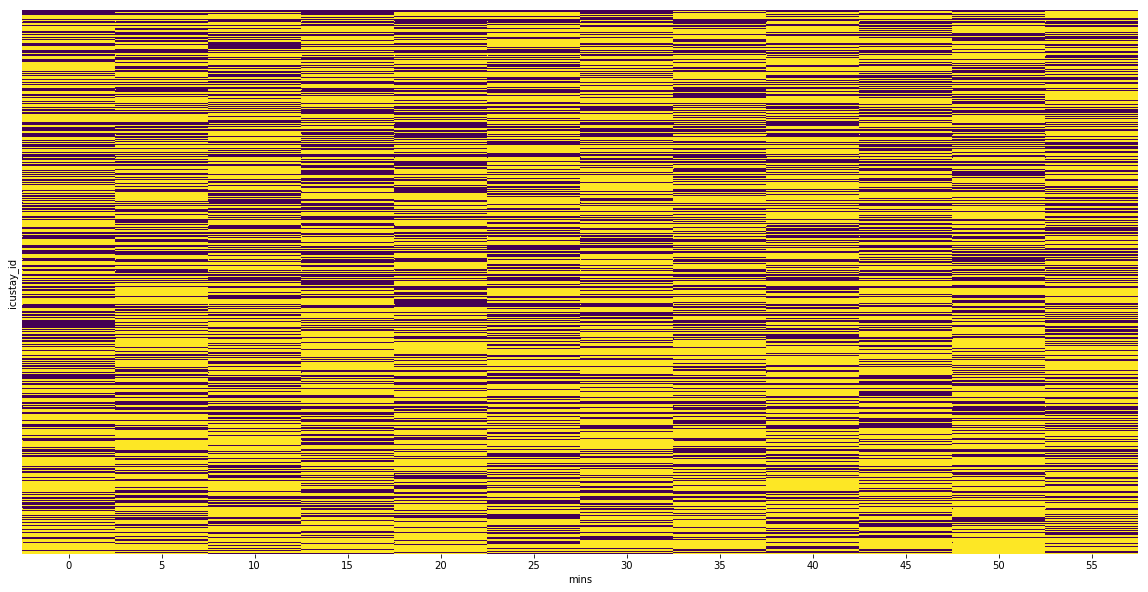

In [20]:
# missing data visualization with heatmap
import seaborn as sns

plt.figure(figsize=(20, 10))

sns.heatmap(mean_pivot.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [21]:
# 결측값 여부 확인 : isnull(), notnull()
# 열별 결측값 갯수 : df.isnull().sum()
# 행별 결측값 갯수 : df.isnull().sum(axis=1)

mean_pivot.isnull().sum(axis=1).sort_values(ascending=True)
mean_pivot.loc[mean_pivot.isnull().sum(axis=1).sort_values(ascending=True).index]

icustay_id
293947.0     0
238684.0     0
280844.0     0
238536.0     0
266954.0     0
291557.0     0
205385.0     0
205383.0     0
267007.0     0
267059.0     0
            ..
258957.0    11
278299.0    11
233948.0    11
233945.0    11
258987.0    11
233921.0    11
288470.0    11
233682.0    11
234357.0    11
286298.0    11
Length: 5484, dtype: int64

mins,0,5,10,15,20,25,30,35,40,45,50,55
icustay_id,,,,,,,,,,,,
293947.0,43.076923,43.636364,56.666667,42.876147,43.333334,42.500000,41.428572,44.000001,43.333334,43.636364,41.111112,44.166667
238684.0,60.000002,89.999998,60.000002,53.110236,69.999999,60.000002,66.666667,47.500000,45.000000,58.043478,48.000001,50.000000
280844.0,47.500001,40.000001,45.992648,60.000002,40.000001,48.333333,40.000001,40.000001,44.545455,50.000000,46.666667,52.000001
238536.0,43.333334,44.000001,40.000001,40.000001,40.769231,42.000000,44.000001,42.857143,40.000001,45.000000,40.375001,40.000001
266954.0,43.333334,43.571429,42.656250,44.166667,43.958334,47.812500,41.666667,40.833334,43.587302,42.000000,42.307693,44.722222
291557.0,58.000002,50.000000,53.333334,45.000000,50.000000,47.586207,50.000001,41.666667,50.000000,48.000000,46.666668,50.714287
205385.0,57.500000,55.000000,60.000000,50.000000,45.000000,63.750000,49.000000,61.666667,50.000000,50.491071,46.666667,50.454545
205383.0,69.999999,46.946108,47.500000,45.000001,40.000001,41.000000,40.000001,45.000001,46.000000,40.000001,55.000000,40.000001
267007.0,75.000000,50.000000,80.000000,65.000000,55.000000,57.000000,65.000000,70.000000,72.500000,81.666667,60.000000,75.833333


In [22]:
mean_pivot.columns
len(mean_pivot.columns)

Int64Index([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55], dtype='int64', name='mins')

12

In [23]:
# missing value가 전체 데이터 갯수의 절반 이상인 경우 제외
mean_pivot = mean_pivot.loc[mean_pivot.isnull().sum(axis=1)<(len(mean_pivot.columns)/2)]
mean_pivot

mins,0,5,10,15,20,25,30,35,40,45,50,55
icustay_id,,,,,,,,,,,,
200102.0,62.500000,65.000001,50.000000,59.999999,69.999999,55.000001,62.500000,56.666668,53.793103,59.999999,55.000001,53.500001
200140.0,53.333333,45.000000,60.000002,50.000000,50.173914,80.000001,40.000001,79.999998,56.000000,40.000001,51.666667,62.500001
200282.0,NaN,100.000000,37.131148,NaN,NaN,75.000000,42.500000,30.000000,NaN,100.000000,45.000000,NaN
200422.0,38.000000,47.250000,NaN,77.500000,53.666667,47.000000,44.000000,43.038700,39.333333,54.250000,48.916667,45.000000
200438.0,40.000001,46.666667,50.000000,40.000001,42.307693,40.000001,45.000000,NaN,45.000000,NaN,43.333334,NaN
200487.0,40.000000,49.000000,37.500000,46.666667,49.000000,NaN,40.000000,51.439394,63.333333,37.500000,47.500000,50.000000
200488.0,40.000001,46.785715,40.000001,40.000001,NaN,60.000002,40.000001,44.285715,47.500001,40.000001,40.000001,NaN
200514.0,NaN,NaN,56.666667,NaN,55.000001,NaN,60.000002,52.500001,60.000002,60.000002,50.000000,65.000001
200639.0,40.000001,38.333334,NaN,39.605264,NaN,40.000001,40.000001,40.000001,NaN,40.000001,40.000001,40.000001


## 결측값 처리하기
- 특정 값으로 채우기 : df.fillna(0)
- 결측값을 앞 방향(forward) 혹은 뒷 방향(backward)으로 채우기 : 앞 df.fillna(method='ffill') or df.fillna(method='pad') 뒤 df.fillna(method='bfill')
    - 앞/뒤 방향으로 결측값 채우는 횟수를 제한하기 : df.fillna(method='ffill', limit=number)
- 결측값을 변수별 평균으로 대체하기 : df.fillna(df.mean()), df.where(pd.notnull(df), df.mean(), axis='columns')
- 결측값을 다른 변수의 값으로 대체하기

시계열 데이터에서 결측값 보간 하기
https://rfriend.tistory.com/264?category=675917

In [24]:
# 나머지 missing value 채우기
mean_pivot = mean_pivot.fillna(method='ffill', limit=1, axis=1)
mean_pivot

mins,0,5,10,15,20,25,30,35,40,45,50,55
icustay_id,,,,,,,,,,,,
200102.0,62.500000,65.000001,50.000000,59.999999,69.999999,55.000001,62.500000,56.666668,53.793103,59.999999,55.000001,53.500001
200140.0,53.333333,45.000000,60.000002,50.000000,50.173914,80.000001,40.000001,79.999998,56.000000,40.000001,51.666667,62.500001
200282.0,NaN,100.000000,37.131148,37.131148,NaN,75.000000,42.500000,30.000000,30.000000,100.000000,45.000000,45.000000
200422.0,38.000000,47.250000,47.250000,77.500000,53.666667,47.000000,44.000000,43.038700,39.333333,54.250000,48.916667,45.000000
200438.0,40.000001,46.666667,50.000000,40.000001,42.307693,40.000001,45.000000,45.000000,45.000000,45.000000,43.333334,43.333334
200487.0,40.000000,49.000000,37.500000,46.666667,49.000000,49.000000,40.000000,51.439394,63.333333,37.500000,47.500000,50.000000
200488.0,40.000001,46.785715,40.000001,40.000001,40.000001,60.000002,40.000001,44.285715,47.500001,40.000001,40.000001,40.000001
200514.0,NaN,NaN,56.666667,56.666667,55.000001,55.000001,60.000002,52.500001,60.000002,60.000002,50.000000,65.000001
200639.0,40.000001,38.333334,38.333334,39.605264,39.605264,40.000001,40.000001,40.000001,40.000001,40.000001,40.000001,40.000001


In [25]:
mean_pivot[mean_pivot.index==200282.0]

mins,0,5,10,15,20,25,30,35,40,45,50,55
icustay_id,,,,,,,,,,,,
200282.0,NaN,100.0,37.131148,37.131148,NaN,75.0,42.5,30.0,30.0,100.0,45.0,45.0


In [26]:
mean_pivot.median(axis=1)

icustay_id
200102.0    58.333334
200140.0    52.500000
200282.0    43.750000
200422.0    47.125000
200438.0    44.166667
200487.0    48.250000
200488.0    40.000001
200514.0    56.666667
200639.0    40.000001
200763.0    40.000001
              ...    
299574.0    50.000000
299634.0    48.571429
299674.0    42.758621
299715.0    50.000000
299728.0    41.555556
299794.0    55.833335
299806.0    41.875000
299816.0    59.872882
299840.0    50.000000
299863.0    50.263158
Length: 1652, dtype: float64

In [27]:
# mean_pivot.fillna(mean_pivot.median(axis=1))
mean_pivot = mean_pivot.where(pd.notnull(mean_pivot), mean_pivot.median(axis=1), axis=0)
mean_pivot

mins,0,5,10,15,20,25,30,35,40,45,50,55
icustay_id,,,,,,,,,,,,
200102.0,62.500000,65.000001,50.000000,59.999999,69.999999,55.000001,62.500000,56.666668,53.793103,59.999999,55.000001,53.500001
200140.0,53.333333,45.000000,60.000002,50.000000,50.173914,80.000001,40.000001,79.999998,56.000000,40.000001,51.666667,62.500001
200282.0,43.750000,100.000000,37.131148,37.131148,43.750000,75.000000,42.500000,30.000000,30.000000,100.000000,45.000000,45.000000
200422.0,38.000000,47.250000,47.250000,77.500000,53.666667,47.000000,44.000000,43.038700,39.333333,54.250000,48.916667,45.000000
200438.0,40.000001,46.666667,50.000000,40.000001,42.307693,40.000001,45.000000,45.000000,45.000000,45.000000,43.333334,43.333334
200487.0,40.000000,49.000000,37.500000,46.666667,49.000000,49.000000,40.000000,51.439394,63.333333,37.500000,47.500000,50.000000
200488.0,40.000001,46.785715,40.000001,40.000001,40.000001,60.000002,40.000001,44.285715,47.500001,40.000001,40.000001,40.000001
200514.0,56.666667,56.666667,56.666667,56.666667,55.000001,55.000001,60.000002,52.500001,60.000002,60.000002,50.000000,65.000001
200639.0,40.000001,38.333334,38.333334,39.605264,39.605264,40.000001,40.000001,40.000001,40.000001,40.000001,40.000001,40.000001


In [28]:
# 확인
mean_pivot[mean_pivot.index==200282.0]

mins,0,5,10,15,20,25,30,35,40,45,50,55
icustay_id,,,,,,,,,,,,
200282.0,43.75,100.0,37.131148,37.131148,43.75,75.0,42.5,30.0,30.0,100.0,45.0,45.0


Text(0.5,1,'Change of FiO2 from admission')

Text(0.5,0,'Minutes after admission')

Text(0,0.5,'% of FiO2')

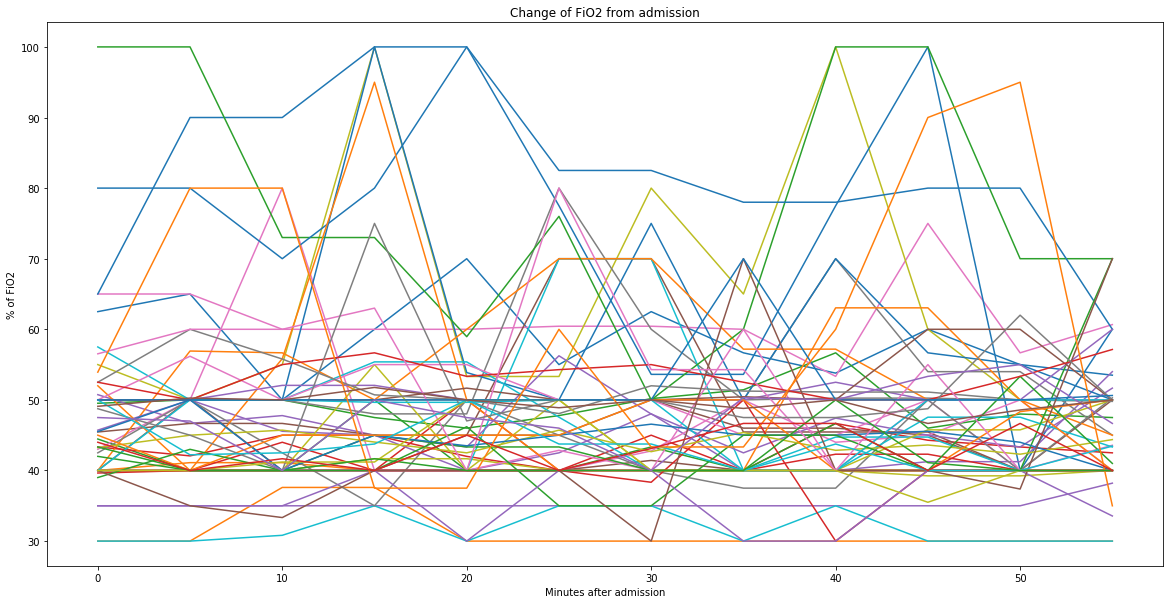

In [29]:
# 시각화해보기 - 전체 데이터는 차트가 너무 지저분해서 일부만을 시각화함(해당 코드의 필요성 고민)
fig = plt.figure(figsize=(20, 10))
index = 0
for m_ind in mean_pivot.index:
    if index % 30 == 0:
        row = mean_pivot.xs(m_ind)
    #     print(row.get_values())
        plt.plot(mean_pivot.columns, row.get_values(), linestyle='-')
    index += 1

plt.title("Change of FiO2 from admission")
plt.xlabel("Minutes after admission")
plt.ylabel("% of FiO2")

### Vanilla LSTM

In [30]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

Using TensorFlow backend.


In [31]:
mean_pivot.shape

(1652, 12)

In [52]:
n_steps = mean_pivot.shape[1]-1
n_features = 1

In [53]:
mean_n = mean_pivot.iloc[:, :-1].values
Y = mean_pivot.iloc[:, -1].values

In [54]:
X = mean_n.reshape((mean_pivot.shape[0], n_steps, n_features))

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10, shuffle=True)
X_train.shape
X_test.shape

(1321, 11, 1)

(331, 11, 1)

In [62]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [63]:
model.fit(X_train, y_train, epochs=200, verbose=0)

In [66]:
y_predict = model.predict(X_test, verbose=0)